# Welcome!
## This is the geo-only version. 


In [7]:
import numpy
import scipy
import matplotlib
import sklearn
import pandas as pd
import itertools
import gensim
import numpy as np

import seaborn as sns
seaborn.set(style='ticks')

%matplotlib inline
import matplotlib.pyplot as plt # matplotlib plots
import matplotlib.gridspec as gridspec # for subplots

import plotly.plotly as py
from plotly.graph_objs import *
import plotly.tools as tls

#import nltk

In [8]:
df = pd.read_csv('Water_Quality_complaints.csv')
census = pd.read_csv('New_York_City_Population_By_Boroughs.csv')

In [9]:
df.head(2)

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,...,Bridge Highway Name,Bridge Highway Direction,Road Ramp,Bridge Highway Segment,Garage Lot Name,Ferry Direction,Ferry Terminal Name,Latitude,Longitude,Location
0,31503046,9/10/15,10/30/15,DEP,Department of Environmental Protection,Water Quality,Clear Water With Other Particles (Use Comments...,NaN,11213.0,1534 PROSPECT PLACE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.672986,-73.925914,"(40.6729859224145, -73.92591381590103)"
1,31539143,9/15/15,9/29/15,DEP,Department of Environmental Protection,Water Quality,Cloudy Or Milky Water (QB1),NaN,10025.0,840 COLUMBUS AVENUE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.796219,-73.965090,"(40.79621920145586, -73.96508964870316)"


## Let's see if the incidents appear to cluster by latitude & longitude: 

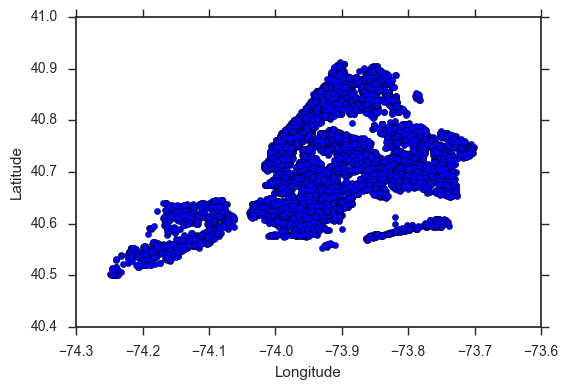

In [10]:
# Compile latitude and longitude of each incident: 
allLat = df['Latitude']
allLon = df['Longitude']

fig3 = plt.figure()
plt.scatter(allLon,allLat)
plt.xlabel('Longitude')
plt.ylabel('Latitude')

In [11]:
# Let's try the same (similar) map as above (long,lat) but using seaborn to color-code the dots by complaint type. 
geoData = pd.concat([df['Longitude'], df['Latitude'], df['Descriptor']], axis=1, keys=['Longitude', 'Latitude','Descriptor'])
geoDataSub = geoData[0:10]
geoDataSub
#Source: Paul H via http://stackoverflow.com/questions/14885895/color-by-column-values-in-matplotlib

,Longitude,Latitude,Descriptor
0,-73.925914,40.672986,Clear Water With Other Particles (Use Comments...
1,-73.965090,40.796219,Cloudy Or Milky Water (QB1)
2,-73.999294,40.623667,"No Sampling Required, Requested Information (QG2)"
3,-73.940048,40.713930,Clear Water With Other Particles (Use Comments...
4,-73.921958,40.819177,Cloudy Or Milky Water (QB1)
5,-73.868404,40.672748,Cloudy Or Milky Water (QB1)
6,-74.007506,40.737561,"Taste/Odor, Chemical (QA2)"
7,-73.893958,40.734743,"Taste/Odor, Chemical (QA2)"
8,-73.893454,40.867269,unknown odor/taste in drinking water (QA6)
9,-73.898736,40.869867,unknown odor/taste in drinking water (QA6)


In [12]:
descList = numpy.unique(geoData['Descriptor'])
descList[0:6]

# descListSub = numpy.unique(geoDataSub['Descriptor'])
# descListSub

array(['BWSO Referral To Water Quality (For DEP Internal Use Only)',
       'Clear Water With Organisms (Insects, Worms) (QE2)',
       'Clear Water With Other Particles (Use Comments) (QEZ)',
       'Cloudy Or Milky Water (QB1)',
       'Cloudy Or Milky, Other (Use Comments) (QBZ)',
       'Defective Water Sampling Station (QSS)'], dtype=object)

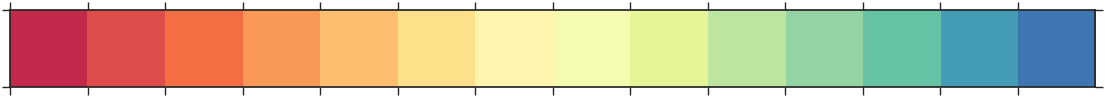

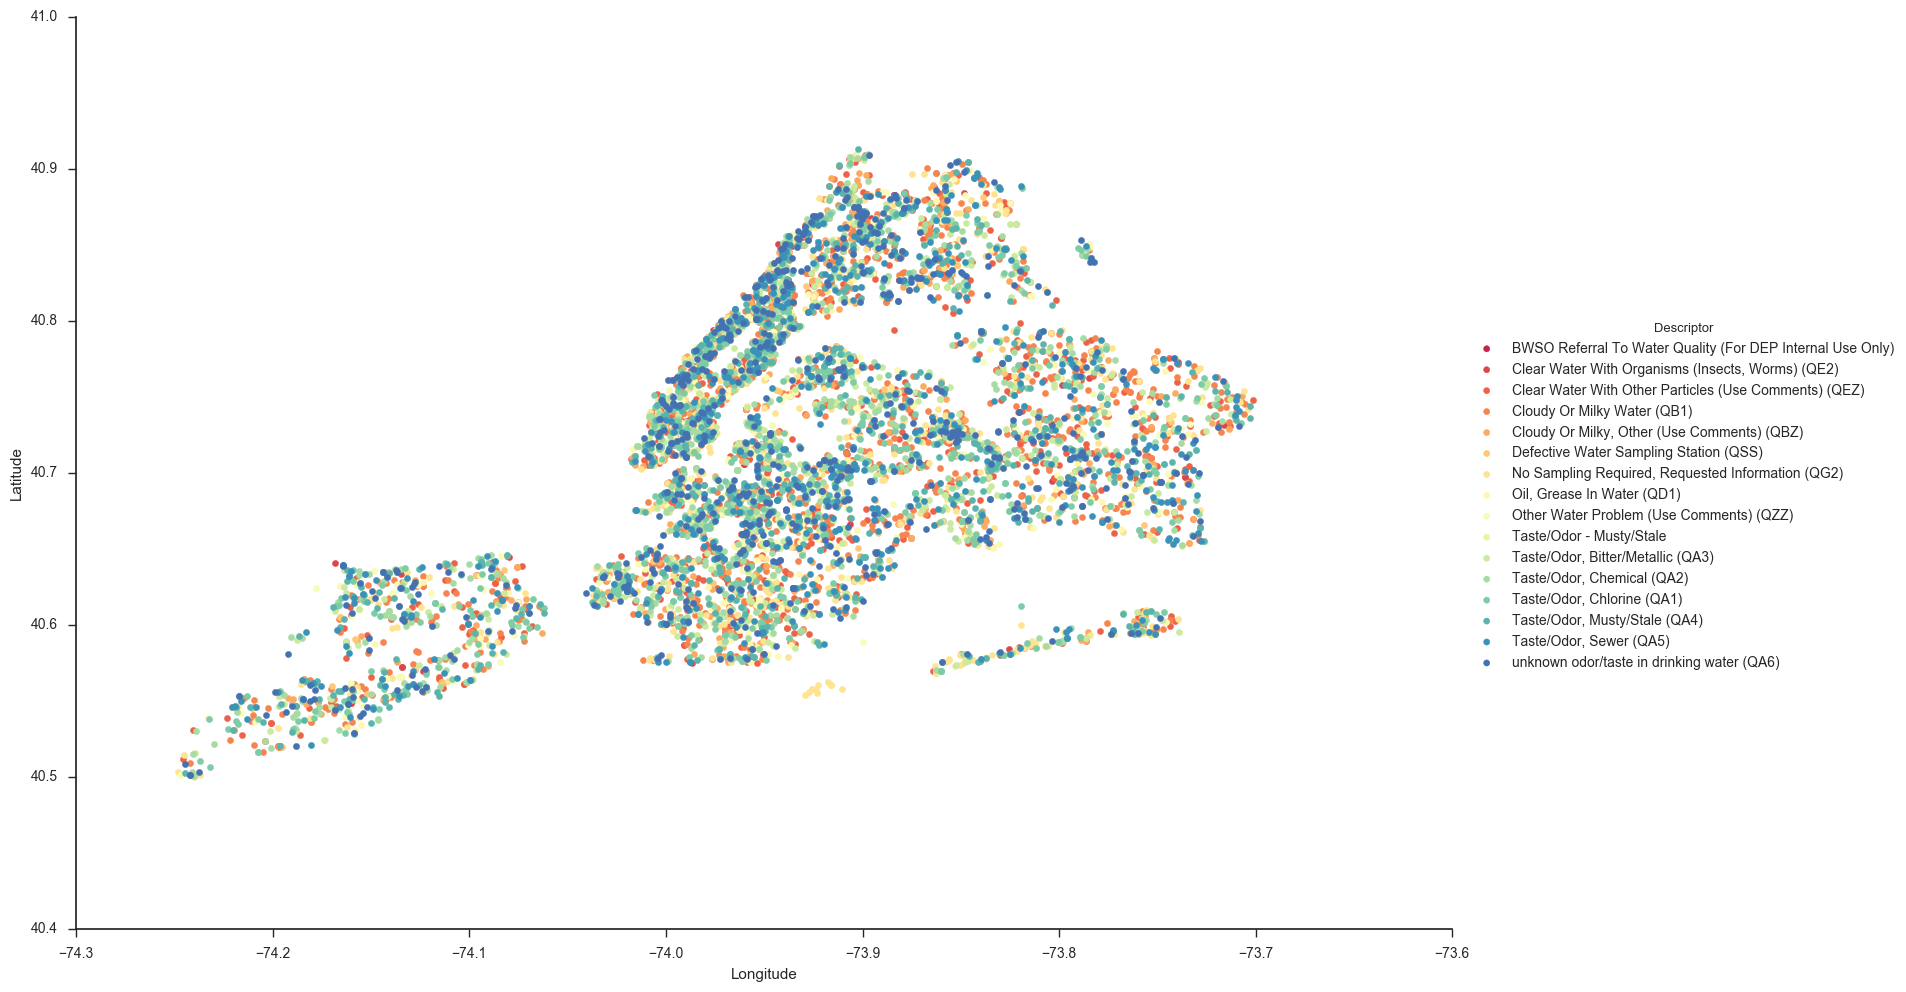

In [13]:
import seaborn 
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"] # custom colors
seaborn.palplot(seaborn.color_palette('Spectral',14))
fg = seaborn.FacetGrid(data=geoData, hue='Descriptor', hue_order=descList, palette="Spectral", size = 10, aspect=1.5)
fg.map(plt.scatter, 'Longitude', 'Latitude').add_legend()


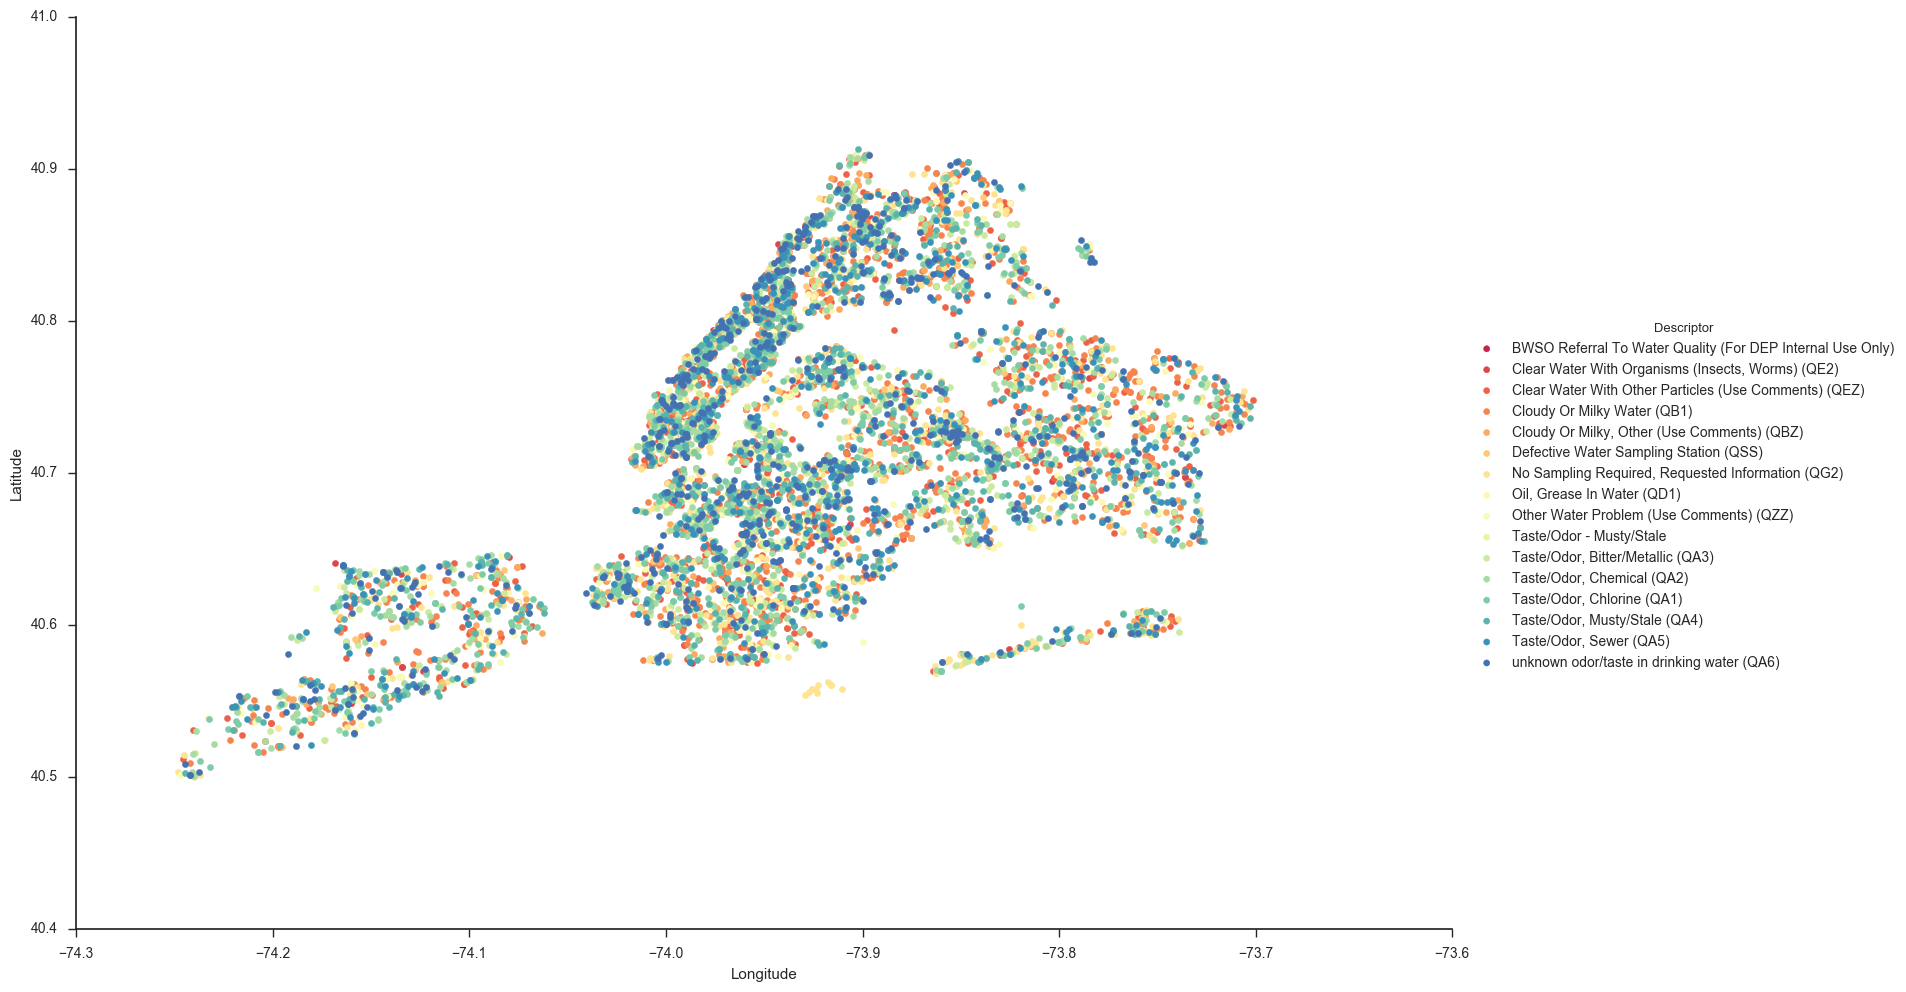

In [14]:
# Want to change all entries with descriptor "Taste/Odor - Musty/Stale" to "Taste/Odor - Musty/Stale (QA4)" and replot
for item in geoData['Descriptor']:
    if item.startswith('Taste/Odor, Musty/Stale'):
        item = 'Taste/Odor, Musty/Stale (QA4)'
fg = seaborn.FacetGrid(data=geoData, hue='Descriptor', hue_order=descList, palette="Spectral", size = 10, aspect=1.5)
fg.map(plt.scatter, 'Longitude', 'Latitude').add_legend()

In [15]:
# # See if it looks better if we use the given x and y coordinates: 
# allX = df['X Coordinate (State Plane)']
# allY = df['Y Coordinate (State Plane)']

# fig4 = plt.figure()
# plt.scatter(allX,allY)

## Seems like we see a good number of complaints in all boroughs, and definitely see barrier islands as well. 

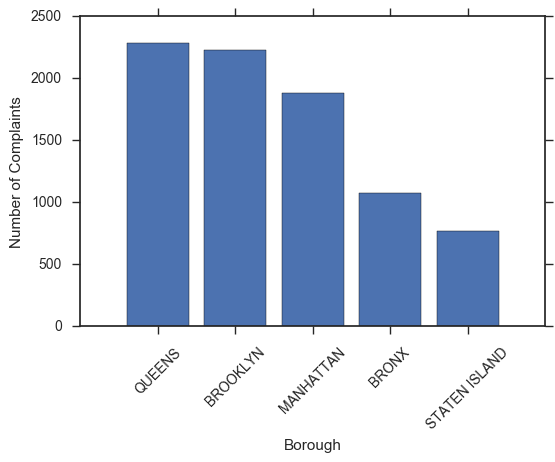

In [16]:
# Let's get a bar plot to see which areas have the most complaints. 
bCounts = df['Borough'].value_counts() # Thanks to AryanJ-NYC and EdChum on StackOverflow
bList = list(bCounts.index)
xpos = range(len(bList))
plt.bar(xpos, bCounts, align='center')
plt.xticks(xpos, bList)
ax = plt.gca()
ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45)
plt.ylabel('Number of Complaints')
plt.xlabel('Borough')


In [17]:
# We would like to normalize to the population of each borough.  
# We have census population data from 2010 (and 2000) in the dataframe 'census'.  
bCounts
#popAndCountsBorough = pd.merge(bCounts, census, on=['Index']

QUEENS           2283
BROOKLYN         2227
MANHATTAN        1882
BRONX            1074
STATEN ISLAND     771
Name: Borough, dtype: int64

In [18]:
bCountsSorted = bCounts.sort_index()
bCountsSorted

BRONX            1074
BROOKLYN         2227
MANHATTAN        1882
QUEENS           2283
STATEN ISLAND     771
Name: Borough, dtype: int64

In [19]:
census['Borough'] = census['Borough'].str.upper()
census

,Borough,2000 Population,2010 Population
0,BRONX,1332650,1385108
1,BROOKLYN,2465326,2504700
2,MANHATTAN,1537195,1585873
3,QUEENS,2229379,2230722
4,STATEN ISLAND,443728,468730


In [20]:
censusBor = census.set_index('Borough')
censusBor

,2000 Population,2010 Population
Borough,,
BRONX,1332650,1385108
BROOKLYN,2465326,2504700
MANHATTAN,1537195,1585873
QUEENS,2229379,2230722
STATEN ISLAND,443728,468730


In [21]:
bCountsNorm = bCounts/censusBor['2010 Population']
bCountsNorm

BRONX            0.000775
BROOKLYN         0.000889
MANHATTAN        0.001187
QUEENS           0.001023
STATEN ISLAND    0.001645
dtype: float64

In [30]:
bCountsNormSeries = pd.Series(bCountsNorm)
bCountsNormSeries

BRONX            0.000775
BROOKLYN         0.000889
MANHATTAN        0.001187
QUEENS           0.001023
STATEN ISLAND    0.001645
dtype: float64

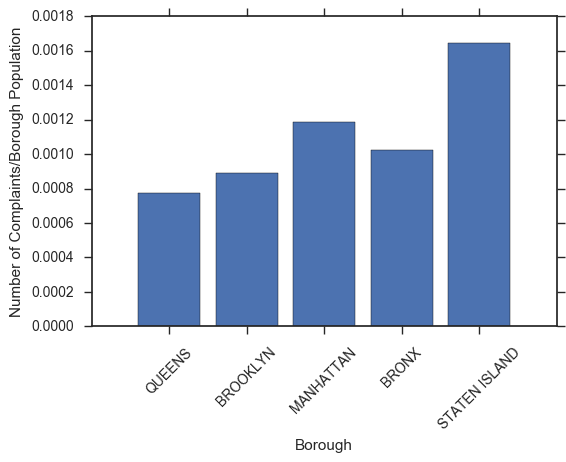

In [27]:
# Let's get a bar plot to see which areas have the most complaints. 
# Have variables from above: bCounts, bList, xpos

plt.bar(xpos, bCountsNorm, align = 'center')
plt.xticks(xpos, bList)
ax = plt.gca()
ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45)
plt.ylabel('Number of Complaints/Borough Population')
plt.xlabel('Borough')

In [31]:
# Let's get a bar plot to see which areas have the most complaints. 
# Have variables from above: bCounts, bList, xpos

sns.barplot(xpos, bCountsNorm)
plt.xticks(xpos, bList)
ax = plt.gca()
ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45)
plt.ylabel('Number of Complaints/Borough Population')
plt.xlabel('Borough')

TypeError: 'range' object is not callable

## Think there may be a seasonal fluctuation to the complaints.  Can try decomposing using a python package that allows us to fit a model that accounts for seasonal fluctuation, overall trend, and noise.  
## (Thanks to AN6U5 on StackOverflow at http://stackoverflow.com/questions/20672236/time-series-decomposition-function-in-python)